# Cuadratura Gaussiana

Uno de los métodos más poderosos para evaluar integrales de forma numérica es la **cuadratura Gaussiana**.

En esta clase vamos a discutir los resultados más importantes y cómo aplicar la idea de cuadraturas para resolver integrales.

Para derivaciones de resultados ver: Computational Physics - Mark Newman Capítulo 5 y Apéndice C.

La idea principal está dada por
\begin{align}
\int_a^b {\rm{d}}x f(x) \approx \sum_{k=1}^{N} w_k f(x_k).
\end{align}
donde:
  * $w_k$ son los "pesos"
  * $x_k$ son los puntos de muestreo
  
Para las ecuaciones de Newton-Cotes de la clase anterior:  
  * Los puntos de muestreo son **equidistantes**.
  * Una ecuación de Newton-Cotes de orden $N$ es *exacta* (i.e., no hay aproximación) para un polinomio de grado $N$.
  * Un polinomio de orden $N$ aproxima una función bien comportada mejor que un polinomio de orden $N-1$, debido al grado de libertad añadido.
  
Por el otro lado, para la cuadratura Gaussiana:
  * Los puntos de muestreo se escogen de manera tal que **no son equidistantes**. Esto introduce más grados de libertad para la misma discretización en $N$ subregiones.
  * Es exacta para un polinomio de orden $(2N - 1)$.
  * Es decir, la cuadratura Gaussiana da la misma precisión que un polinomio de orden $(2N - 1)$.

No vamos a probar el siguiente resultado (ver Apéndice C de Newman - Computational Physics), pero de manera muy interesante, existe una **regla universal para escoger $w_k$ y $x_k$**. Los pesos y puntos de muestreo se eligen tal que:
  * $x_k$ corresponden a las $N$ raíces (ceros) de los polinomios de Legendre $P_N(x)$ de orden $N$.
  * Los pesos se eligen tal que:
      - $\displaystyle w_k = \left[\frac{2}{1-x^2}\left(\frac{dP_N}{dx}\right)^{-2}\right]_{x={x_k}}$, con $x_k$ que cumple $P_N(x_k)=0$

Hablemos de los pros y los contras del uso de cuadraturas Gaussianas para evaluar integrales.

* Pros:
  - La ecuación para evaluar los errores es muy complicada. Sin embargo, la aproximación mejora con un error que decrece por un factor ${\rm{const.}} / N^2$ cuando se incrementa el número de subregiones de discretización en uno.
  - Ejemplo: Pasar de $N=10$ a $N=11$, mejora el resultado de la estimación por un factor de $\approx 100$. Esto indica que la convergencia ocurre con muy pocos puntos de muestreo.
  
* Cons:
  - Sólo funciona bien su la función a integrar es relativamente bien comportada. Si no lo es, se requiren más puntos de muestreo cerca de las regiones problemáticas.
  - Es muy complicado evaluar el error de manera precisa si lo necesitamos.

## Polinomios de Legendre

Los polinomios de Legendre son un sistema de polinomios ortogonales que pueden ser definidos de manera recursiva. Tenemos:
\begin{align}
\forall (M, N) \in\mathbb N^2, \quad \int_{-1}^1 {\rm{d}}x P_N(x)P_M(x) = \frac{2\delta_{MN}}{2N+1}.
\end{align}
Note que los polinomios están definidos en el intervalo $[-1, 1]$.
Los se definen empezando con
\begin{align}
P_0(x) = 1 \Rightarrow P_1(x) = x,
\end{align}
tal que los siguientes órdenes se generan con la regla de recursividad
\begin{align}
(N+1)P_{N+1}(x) = (2N+1)xP_N(x) -NP_{N-1}(x).
\end{align}
Alternativamente, los polinomios pueden ser definidos de manera iterativa bajo la regla (fórmula de Rodrigues)
\begin{align}
P_N(x) = \frac1{2^N N!}\frac{d^N}{dx^N}\left[(x^2-1)^N\right].
\end{align}

En la computadora, podemos utilizar `SciPy` para obtener los polinomios de Legendre:

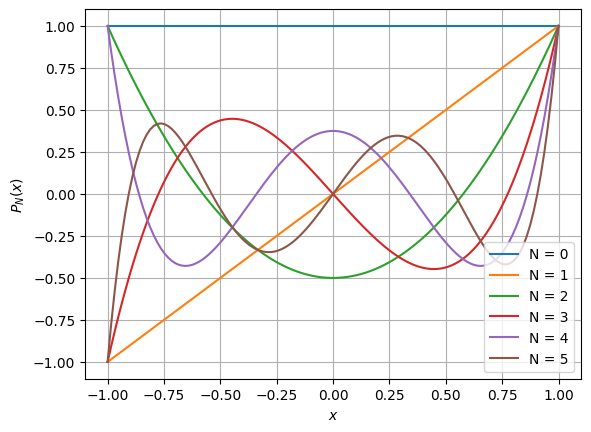

In [6]:
from scipy.special import legendre
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-1, 1, 128)
plt.figure(dpi=100)
for N in range(6):
    plt.plot(x, legendre(N)(x), label='N = {}'.format(N))
plt.grid()
plt.xlabel("$x$")
plt.ylabel("$P_N(x)$")
plt.legend()
plt.show()

Una vez que conocemos los polinomios de Legendre, debemos encontrar sus raíces y calcular los pesos de acuerdo con la regla que describimos al inicio de este notebook.

Esto es un procedimiento ligeramente costoso dependiendo de la metodología que se utilice. La idea es que si necesitamos evaluar la integral utilizando distintos intervalos de integración, primero realizamos el cálculo de los puntos de muestreo $x_k$ y los pesos $w_k$ en el intervalo $[-1, 1]$. Posteriormente, podemos escalar los parámetros para ser modificados a un intervalo $[a, b]$ (ver pags 167-168 Newman).

El siguiente código calcula los $x_k$ y  los $w_k$ utilizando **código vectorial**. Es decir, las funciones se aplican a **arreglos de datos** (en este caso de `Numpy`), en lugar de realizar `for loops` sobre todas las variables. 

Por ejemplo:

In [7]:
x_test = np.linspace(-1.0, 1.0, 5)

print(np.sin(x_test))

[-0.84147098 -0.47942554  0.          0.47942554  0.84147098]


Note que `Numpy` puede tomar como argumentos `np.ndarray`, de manera tal que no tenemos que hacer `for loops` para evaluar la función en cada argumento por separado. **Esto es muy importante**, dado que los `for loops` en `Python` son extremadamente lentos, mientras que las funciones de `NumPy` vectoriales están compiladas y enlazadas con código compilado.

Veamos el código que calcula los $x_k$ y los $w_k$. La biblioteca `Numpy` nos permite evaluar los pesos y los puntos de muestreo para utilizar la cuadratura Gaussiana con polinomios de Legendre:

In [8]:
def gaussxw(N):
    x, w = np.polynomial.legendre.leggauss(N)
    
    return x, w

Este código se vuelve paulatinamente más costoso conforme aumentamos $N$ y solo funciona para intervalos de integración $[-1, 1]$. Para escalar el intervalo a un $[a, b]$ general, podemos utilizar la siguiente rutina:

In [9]:
def gaussxwab(a, b, x, w):
    # Obtenido de pag 168 Newman)
    # Note que esta función está escrita a-la-Pitón: si funciona bueno; si no, es culpa suya.
    return 0.5 * (b - a) * x + 0.5 * (b + a), 0.5 * (b - a) * w

Una vez que tenemos los puntos de muestreo y los pesos, evaluar integrales es **trivial**. Basta con utilizar la regla:
\begin{align}
\int_a^b {\rm{d}}x f(x) \approx \sum_{k=1}^{N} w_k f(x_k).
\end{align}

Hagamos una prueba. Integremos una función muy sencilla, dada por:
\begin{align}
f(x) = x^4 - 2x^3 + 1,
\end{align}
en el intervalo $[0, 2]$.
Lo primero es calcular los puntos de muestreo y los pesos.

In [10]:
# Hágalo primero para $N=2$:
# Su código aquí

# Luego para $N=3$
# Su código aquí

# Y finalmente para $N=4$
# Su código aquí

Ahora tenemos que escalar los pesos y los puntos de muestreo:

In [11]:
# Su código aquí

Y ahora evaluamos la integral utilizando $N = 2, 3, 4$: (para esta parte del código, recuerde que nuestros parámetros están guardados en arreglos de datos de tipo `np.ndarray`, de manera que podemos utilizar notación vectorial! La función `np.sum` también es muy útil en este caso para evitar `for loops`!)

In [12]:
# Su código aquí

Para $N=3$, la solución es exacta con excepción de precisión de máquina! A qué se debe esto? 

# Ajustes de mínimos cuadrados

A pesar de que se confunden usualmente, la interpolación no es lo mismo que un ajuste. 

* Cuando nuestros datos contienen ruido y/o fluctuaciones, probablemente queremos utilizar ajustes. Mientras que cuando nuestros datos son considerados fidedignos, utilizamos interpolaciones.
* En la Física, usualmente nos enfrentamos a distintos tipos de ajustes: polinomiales, exponentiales, potencias, Gaussianos...
* Los métodos más comunes para realizar esto son: **mínimos cuadrados** y **regresión lineal**
* En esta parte del curso, vamos a utilizar uno de los pragmas fundamentales de la computación científica: por más que se vea tentado/a, *no escriba sus propias rutinas*. Utilice **bibliotecas**.
* En este ejercicio vamos a demostrar como utilizar mínimos cuadrados para un ajuste polinomial.

## Ajuste polinomial 

Vamos a crear un conjunto artificial de datos ruidosos, para analizar que tipo de ajuste polinomial es más apropiado.

Asumamos que tenemos un conjunto que sigue una línea recta, pero le añadimos ruido aleatorio.

In [13]:
x = np.arange(50.0)
y = x + 50.0 * np.random.random(50)

Veamos como se ve este conjunto de datos:

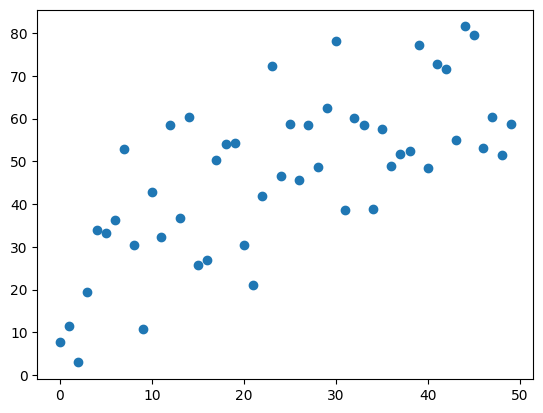

In [14]:
plt.plot(x, y, 'o')
plt.show()

Ahora intentemos utilizar mínimos cuadrados para ajustar una línea recta a los datos:

In [15]:
# El tercer argumento es el orden del polinomio
linfit = np.polyfit(x, y, 1)

# El resultado es un arreglo con dos parámetros: la pendiente y el intercepto,
# de manera tal que el mejor ajuste es: y = linfit[0] * x + linfit[1]
linfit

array([ 0.91963238, 24.71766331])

Ahora probemos con un ajuste a un polinomio cuadrático:

In [16]:
quadfit = np.polyfit(x, y, 2)

# El resultado es un arreglo de tres parámetros que contiene: el coeficiente cuadrático, el coeficiente lineal
# y el coeficiente constante
# y = quadfit[0] * x^2 + quadfit[1] * x + quadfit[2]
quadfit

array([-0.02115915,  1.95643067, 16.42327695])

Podemos evaluar nuestra variable independiente en el ajuste obtenido:

In [17]:
y_linfit = np.polyval(linfit, x)
y_linfit

array([24.71766331, 25.63729569, 26.55692806, 27.47656044, 28.39619281,
       29.31582519, 30.23545757, 31.15508994, 32.07472232, 32.99435469,
       33.91398707, 34.83361944, 35.75325182, 36.6728842 , 37.59251657,
       38.51214895, 39.43178132, 40.3514137 , 41.27104608, 42.19067845,
       43.11031083, 44.0299432 , 44.94957558, 45.86920795, 46.78884033,
       47.70847271, 48.62810508, 49.54773746, 50.46736983, 51.38700221,
       52.30663458, 53.22626696, 54.14589934, 55.06553171, 55.98516409,
       56.90479646, 57.82442884, 58.74406121, 59.66369359, 60.58332597,
       61.50295834, 62.42259072, 63.34222309, 64.26185547, 65.18148785,
       66.10112022, 67.0207526 , 67.94038497, 68.86001735, 69.77964972])

In [18]:
y_quadfit = np.polyval(quadfit, x)
y_quadfit

array([16.42327695, 18.35854847, 20.2515017 , 22.10213662, 23.91045325,
       25.67645158, 27.40013162, 29.08149335, 30.72053679, 32.31726193,
       33.87166877, 35.38375732, 36.85352756, 38.28097951, 39.66611316,
       41.00892852, 42.30942557, 43.56760433, 44.78346479, 45.95700695,
       47.08823082, 48.17713638, 49.22372365, 50.22799262, 51.1899433 ,
       52.10957567, 52.98688975, 53.82188553, 54.61456301, 55.3649222 ,
       56.07296309, 56.73868567, 57.36208997, 57.94317596, 58.48194366,
       58.97839305, 59.43252415, 59.84433696, 60.21383146, 60.54100767,
       60.82586558, 61.06840519, 61.2686265 , 61.42652952, 61.54211424,
       61.61538066, 61.64632878, 61.63495861, 61.58127013, 61.48526336])

Finalmente, visualicemos nuestros resultados.

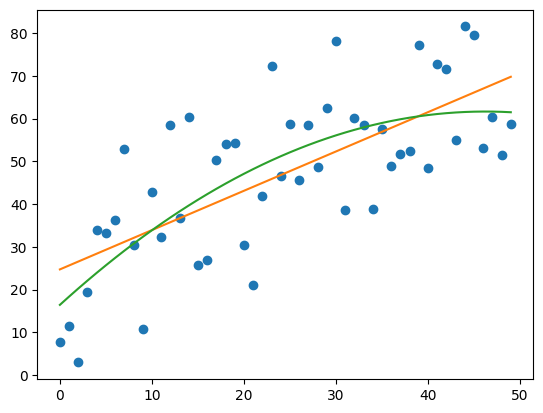

In [19]:
plt.plot(x, y, 'o')
plt.plot(x, y_linfit)
plt.plot(x, y_quadfit)
plt.show()

Como esperabamos, nuestro ajuste se acopla a un ajuste lineal con fluctuaciones, de manera tal que ambos ajustes apuntan a un segemento lineal y casi lineal (para el caso del ajuste cuadrático, con un coeficiente cuadrático muy pequeño). `np.polynomial` nos da funcionalidad para realizar ajustes más complejos como Chebyshev, Hermite, Laguerre, Legendre, etc. Ver la documentación para más información.

P.D.: estos ajustes forman la base fundamental de los algoritmos de machine learning modernos :)